In [27]:
#%pip install protobuf-compiler
#%pip install protobuf==3.20.*
#%pip install tensorflow_hub
#%pip install --upgrade tensorflow-estimator==2.3.0
#%pip install --force-reinstall tensorflow


import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time
import tempfile
from PIL import Image, ImageOps



def resize_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    _, resized_temp_filename = tempfile.mkstemp(suffix=".jpg")
    pil_image.save(resized_temp_filename, format="JPEG", quality=90)

    return resized_temp_filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    detections = {key: value.numpy() if isinstance(value, tf.Tensor) else value for key, value in result.items()}

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    return image_with_boxes, detections

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                            int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)



In [28]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
detector = hub.load(module_handle).signatures['default']

food = np.array( [["Apple",14,0.52,0.78],
                  ["Banana",439,0.89,0.91],
                  ["Bread",420,3.15,0.18],
                  ["Doughnut",566,4.34,0.31],
                  ["Egg",217,1.43,1.03],
                  ["Grape",223,0.69,0.97],
                  ["Lemon",435,0.29,0.96],
                  ["Mango",513,0.60,1.07],
                  ["Orange",481,0.63,0.90],
                  ["Peach",492,0.57,0.96],
                  ["Pear",341,0.39,1.02]])

#coin: 132
#plate: 312

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [29]:
import cv2

def run_grabcut(image_path, detections, food_index):
    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    for box, detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        
        # Convert the bounding box from fractions to pixel coordinates
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        if detections['detection_class_entities']== int(food[food_index][1]):
            # Create a mask with zeros, same size as the image
            mask = np.zeros((height, width), np.uint8)

            # Create a binary mask with foreground set to 1 inside the bounding box
            mask[ymin:ymax, xmin:xmax] = 1

            # Initialize the GrabCut algorithm
            bgd_model = np.zeros((1, 65), np.float64)
            fgd_model = np.zeros((1, 65), np.float64)

            # Run the GrabCut algorithm with the initial mask
            cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

            # Create a binary mask where the foreground is True (3 and 1 are the possible states of the mask)
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

            # Multiply the original image with the binary mask to get the segmented image
            segmented_image = image * mask2[:, :, np.newaxis]
            # Display the original image and the segmented image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Segmented Image')
            print(ymin, xmin, ymax, xmax)
            plt.show()

            return segmented_image, ymin, xmin, ymax, xmax
  

def coin_pixels(detections):
    
    for box, detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        
        # Convert the bounding box from fractions to pixel coordinates
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        if detections['detection_class_entities']== 132:
            return ymin, xmin, ymax, xmax

In [30]:
def process_images(image_path, image_path1):
    
    resized_image_path = resize_image(image_path, new_width=256, new_height=256, display=True)
    downloaded_image_path = resize_image(image_path, 1280, 856, True)
    image_with_boxes, detections = run_detector(detector, image_path)
    max_score = max(detections['detection_scores'])
    print(max_score)

    for detections['detection_scores'],detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        #print(detections['detection_class_entities'])
        for i in range(len(food)):
            
            if detections['detection_class_entities'] == int(food[i][1]):
                
                food_index = i

    segmented_image_s,ymin_s, xmin_s, ymax_s, xmax_s = run_grabcut(image_path, detections,food_index)

    downloaded_image_path = resize_image(image_path1, 1280, 856, True)
    image_with_boxes, detections = run_detector(detector, image_path1)
    display_image(image_with_boxes)
    
    segmented_image_t,ymin_t, xmin_t, ymax_t, xmax_t = run_grabcut(image_path1, detections, food_index)

    coin_diameter_mm = 25.0
    coin_diameter_pixel = 94.49  
    pixel_per_mm = calculate_pixel_per_unit(coin_diameter_mm, coin_diameter_pixel)

    # Calcolo del fattore di conversione da millimetri a pixel
    conversion_factor = coin_diameter_mm / coin_diameter_pixel

    # Calcolo delle dimensioni dell'area del box in millimetri utilizzando il fattore di conversione
    top_view_box_width_mm = (xmax_t - xmin_t) * conversion_factor
    top_view_box_height_mm = (ymax_t - ymin_t) * conversion_factor

    side_view_box_width_mm = (xmax_s - xmin_s) * conversion_factor
    side_view_box_height_mm = (ymax_s - ymin_s) * conversion_factor

    volume = (top_view_box_width_mm*side_view_box_height_mm*top_view_box_height_mm)/1000
    weight= volume * float(food[food_index][3])
    energy = float(food[food_index][2])

    estimated_calories = energy * weight

    print("Estimated dimensions of the food box from the top view (length x height)", top_view_box_width_mm, "mm x", top_view_box_height_mm, "mm")
    print("Estimated dimensions of the food box from the side view (length x height)", side_view_box_width_mm, "mm x", side_view_box_height_mm, "mm")
    print("Estimated weight:", weight, "g")
    print("Estimated volume:", volume, "cm^3")
    print("Estimated calories:", estimated_calories, "calories")

    #weight_string = "Estimated weight:"+  weight + "g"
    #volume_string = "Estimated volume:"+ volume + "cm^3"
    #calories_volume = "Estimated calories:" + estimated_calories + "calories"
    weight_string = "Estimated weight:" + str(weight) + "g"
    volume_string = "Estimated volume:" + str(volume) + "cm^3"
    calories_string = "Estimated calories:" + str(estimated_calories) + "calories"

    return weight_string, volume_string, calories_string

def calculate_pixel_per_unit(coin_diameter_mm, coin_diameter_pixel):
    pixel_per_unit = coin_diameter_pixel / coin_diameter_mm
    return pixel_per_unit

Avvio del processo...
Found 100 objects.
Inference time:  32.98213219642639
Font not found, using default font.
0.7600733
222 434 387 611


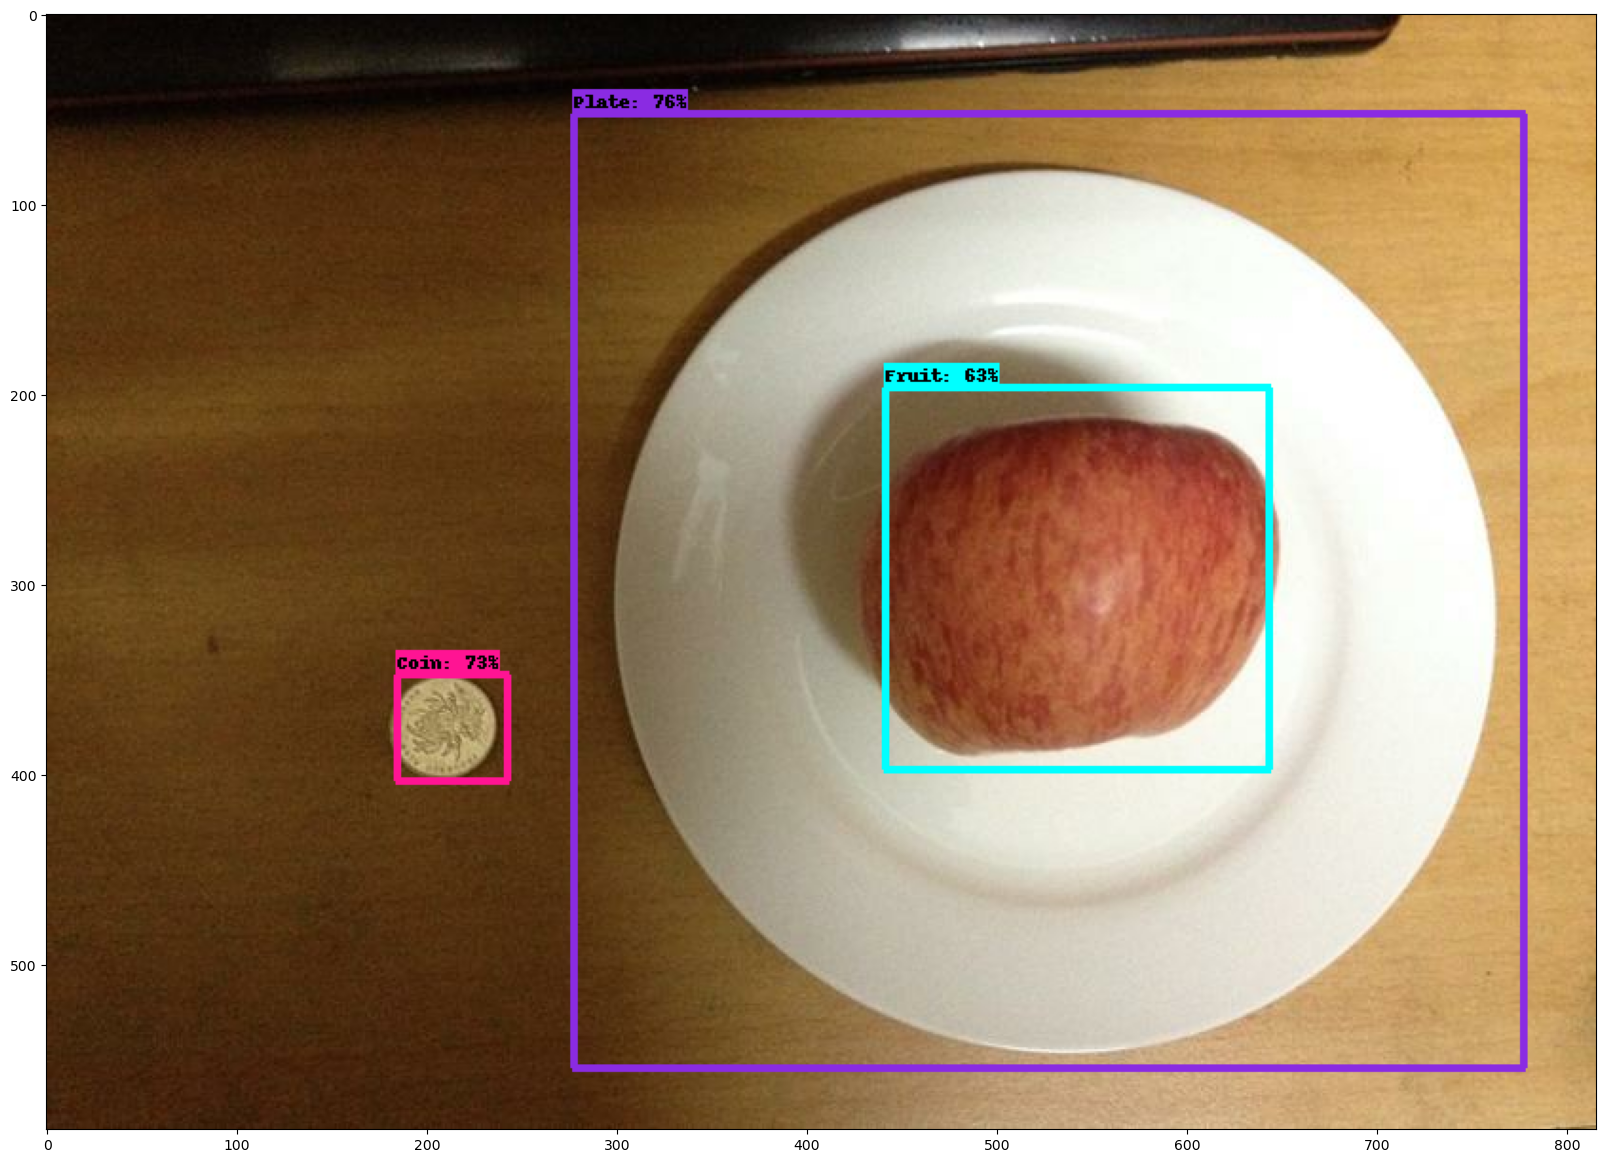

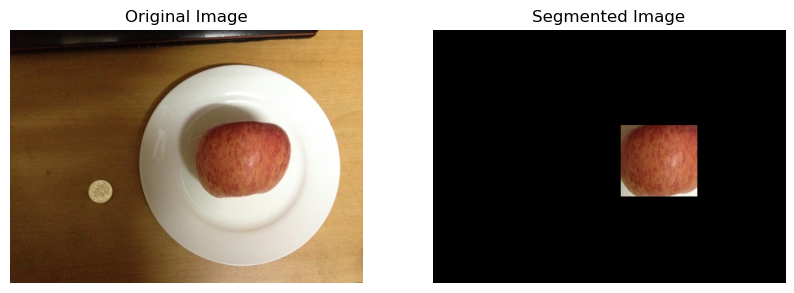

Found 100 objects.
Inference time:  38.022931814193726
Font not found, using default font.
178 392 426 618


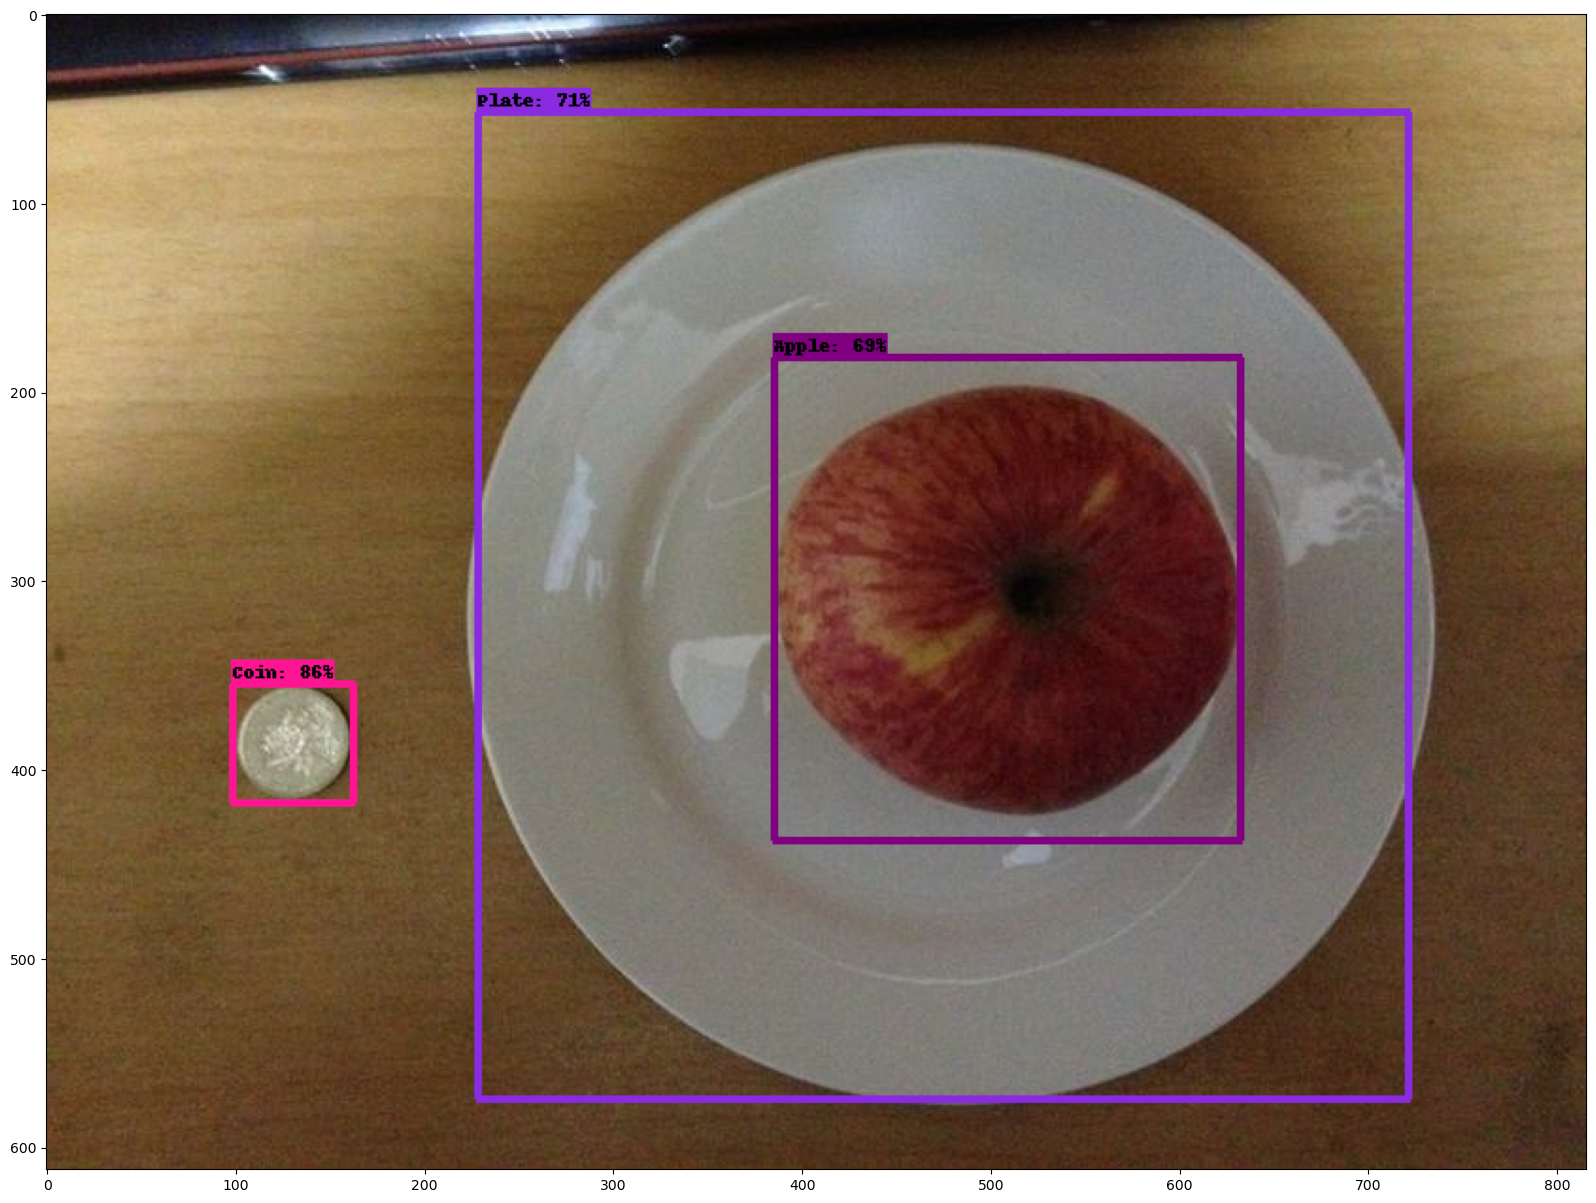

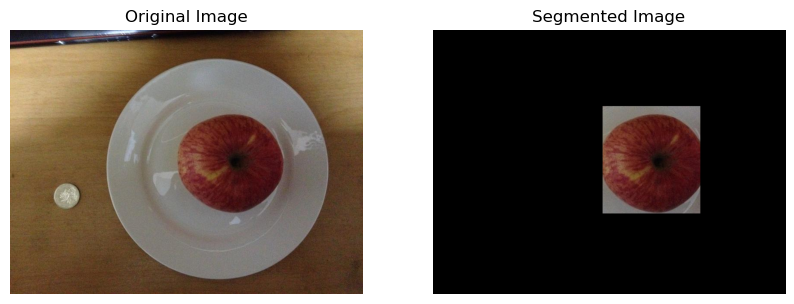

Estimated dimensions of the food box from the top view (length x height) 59.79468726849402 mm x 65.61540903799344 mm
Estimated dimensions of the food box from the side view (length x height) 46.83035241824532 mm x 43.655413271245635 mm
Estimated weight: 166.14155751681463 g
Estimated volume: 171.27995620290167 cm^3
Estimated calories: 114.63767468660208 calories


In [32]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

def load_images_and_process():
    image_path = filedialog.askopenfilename()
    image_path1 = filedialog.askopenfilename()
    
    if image_path and image_path1:
        print("Avvio del processo...")
        weight_string, volume_string, calories_string = process_images(image_path, image_path1)
        label_text = tk.Label(root, text= weight_string + volume_string + calories_string)
        label_text.config(text=weight_string + volume_string + calories_string)
        label_text.pack()
        display_images(image_path, image_path1)

    #display_image(image_path, image_path1)
    

def display_images(image_path1, image_path2):
    # Carica le immagini utilizzando Pillow
    img1 = Image.open(image_path1)
    img2 = Image.open(image_path2)

    # Crea oggetti ImageTk per l'uso in Tkinter
    img1_tk = ImageTk.PhotoImage(img1)
    img2_tk = ImageTk.PhotoImage(img2)

    # Crea finestre separate per le immagini
    image_window1 = tk.Toplevel(root)
    label1 = tk.Label(image_window1, image=img1_tk)
    label1.pack()


root = tk.Tk()
root.title("Elaborazione di Immagini")

# Imposta le dimensioni della finestra principale
root.geometry("600x400")

# Pulsante per caricare due immagini
load_button = tk.Button(root, text="Carica Immagini", command=load_images_and_process)
load_button.pack()

#weight_string, volume_string, calories_string = process_images(image_path, image_path1)

# Crea le label per il testo sotto le immagini
#label_text = tk.Label(root, text= weight_string + volume_string + calories_string)
#label_text.pack()

# Esegui l'applicazione GUI
root.mainloop()